### Visualizations of MNIST training

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
from jax import jit
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import jaxley as jx
from jaxley_retina.mnist.image_to_stim import stimulus_from_image
from jaxley_retina.mnist.simple_data_prep import build_train_loader

2025-10-31 15:51:45.376485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761922305.387587  348727 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761922305.390791  348727 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761922305.399465  348727 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761922305.399486  348727 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761922305.399488  348727 computation_placer.cc:177] computation placer alr

In [4]:
# Config file example
model_config = {
    'BC_readouts': True,
    'use_benison': True, # use simpler calcium dynamics from Benison et al. 2001
    'connections': 'full', # connectivity of cones and HCs
    'nHCs': 1,
    'nPRs': 200,
    'n_readouts': 10,
    'ptc_path': '../../params/cascade/params_3.pkl',
    'ribbon_path': '../../params/ribbon/best_20_params.pkl',
    'model_builder': 'jaxley_retina.mnist.model'
}
stim_config = {
    'digits': 'all',
    'dt': 0.025, # ms
    'outer_ramp_up': 1000, # ms
    'peak_end': 50, # ms
    'peak_start': 0, # ms
    'var': 'PR_Phototransduction_Stim',
    'stim_max': 40_000, # P*/s, maximum cone input
    't_max': 200, # ms, shorter would be too fast for the glutamate release timescale
    'test_contrast_max': 1.0,
    'test_contrast_min': 0.1,
    'test_lum_max': 0.1, # 0.0 for testing OOD accuracy
    'test_lum_min': 0.0,
    'train_contrast_min': 0.1, # changed when testing for OOD accuracy
    'train_contrast_max': 1.0,
    'train_lum_max': 0.1, # 0.0 for testing OOD accuracy
    'train_lum_min': 0.0
}
train_config = {
    # Parameter initializations and constraint bounds
    'IonotropicSynapse_gS_init': 'normal',
    'IonotropicSynapse_gS_init_mean': 0.01,
    'IonotropicSynapse_gS_init_std': 0.001,
    'IonotropicSynapse_gS_lower': -20,
    'IonotropicSynapse_gS_upper': -3,
    'RibbonHC_gS_init': 'normal',
    'RibbonHC_gS_init_mean': 1.0e-07,
    'RibbonHC_gS_init_std': 1.0e-08,
    'RibbonHC_gS_lower': -25,
    'RibbonHC_gS_upper': -5,
    'RibbonReadout_gS_init': 'normal',
    'RibbonReadout_gS_init_mean': 1.0e-06,
    'RibbonReadout_gS_init_std': 1.0e-07,
    'RibbonReadout_gS_lower': -20,
    'RibbonReadout_gS_upper': -3,
    # Learning schedule specs
    'batch_size': 32,
    'checkpoint_lengths': [20, 20, 20],
    'decay_rate': 0.9,
    'loss_start': 0, # ms
    'max_epochs': 5,
    'seed': 0,
    'start_lr': 0.01,
    'stop_criteria': 0.995,
    'transition_steps': 1000,
}

_ = np.random.seed(train_config['seed'])


In [5]:
# Build the model
model_builder = importlib.import_module(model_config["model_builder"])
network = model_builder.build_mnist_model(model_config)

# Set up the parameter training (according to the model)
network, transform = model_builder.setup_param_training(network, train_config)

Number of newly added trainable parameters: 2000. Total number of trainable parameters: 2000
Number of newly added trainable parameters: 200. Total number of trainable parameters: 2200
Number of newly added trainable parameters: 200. Total number of trainable parameters: 2400


In [6]:
# Record activity of readouts
network.delete_recordings()
readout_inds = network.readout.nodes.global_cell_index.tolist()
network.cell(readout_inds).record("v")

# Also record the activity of the other cells
network.PR.record("v")
if model_config["nHCs"] > 0:
    network.HC.record("v")
network.RibbonHC.record("RibbonHC_exo")

Added 10 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.


In [7]:
# Do the ramp-up for the network and save the states
PR_inds = network.PR.nodes.global_cell_index.tolist()
ramp_up_time = np.arange(0, stim_config["outer_ramp_up"], stim_config["dt"])
ramp_up_stim = np.zeros((len(PR_inds), len(ramp_up_time)))

# Initial parameters
init_params = network.get_parameters()

data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], ramp_up_stim, None)
init_soln, init_states = jx.integrate(
    network,
    delta_t=stim_config["dt"],
    data_clamps=data_clamps,
    params=init_params, 
    return_states=True
)

In [8]:
if isinstance(train_config["checkpoint_lengths"], int):
    assert(train_config["checkpoint_lengths"] > 0), "Checkpoint lengths must be > 0"
    levels = train_config["checkpoint_lengths"]
    num_timesteps = int(stim_config["t_max"] / stim_config["dt"])
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
else:
    checkpoints = train_config["checkpoint_lengths"]

@jit
def simulate(params, stim):
    data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], stim, None)
    soln = jx.integrate(
        network, 
        delta_t=stim_config["dt"],
        data_clamps=data_clamps,
        params=params,
        all_states=init_states,
        checkpoint_lengths=checkpoints
    )
    return soln[:, :-1]

In [9]:
# Stimuli prep
network.PR.compute_compartment_centers()
coords = np.vstack((network.PR.nodes.x, network.PR.nodes.y))

In [10]:
# Training loop
ds_train, = build_train_loader(
    train_config["batch_size"], 
    digits=stim_config["digits"],
    contrast_range=(stim_config["train_contrast_min"], stim_config["train_contrast_max"]),
    lum_range=(stim_config["train_lum_min"], stim_config["train_lum_max"]),
    splits=["train"]
)
imgs, labels = next(ds_train)


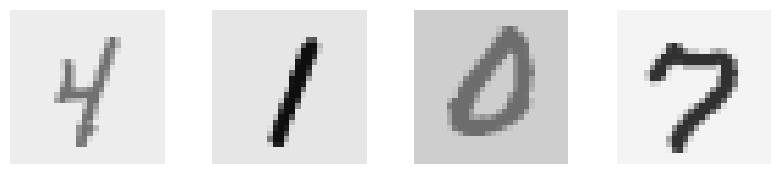

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))

for i in range(4):
    axs[i].imshow(imgs[i], cmap='binary', vmin=0, vmax=1)
    axs[i].axis("off")

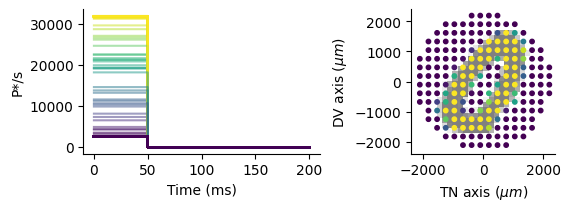

In [12]:
# Plot to confirm that the stimulus is correct
imgs, labs = next(ds_train)
stim = stimulus_from_image(imgs[0], coords, stim_config)

time = np.arange(0, stim_config["t_max"], stim_config["dt"])
fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

# Determine the colors
peak_time = np.average([stim_config["peak_start"], stim_config["peak_end"]])
intensities = stim[:, int(peak_time/stim_config["dt"])]
intensities_rescaled = (intensities - np.min(intensities))/(np.max(intensities) - np.min(intensities))
colors = plt.cm.viridis(intensities_rescaled)

for i in range(stim.shape[0]):
    axs[0].plot(time, stim[i, :], c=colors[i], alpha=0.5)
axs[0].set_ylabel("P*/s")
axs[0].set_xlabel("Time (ms)")

# Where you want the image to appear on the scatter plot [left, right, bottom, top] in scatter plot coordinates
desired_extent = [-2400, 2400, -2400, 2400]
# Create an image artist and add it to the plot with transparency
img_artist = axs[1].imshow(
    imgs[0, :, :, 0], extent=desired_extent, alpha=0.5, aspect='auto', zorder=0, cmap='binary', origin='upper'
    )  # zorder=0 puts it behind the scatter

axs[1].scatter(coords[0], coords[1], c=intensities_rescaled, cmap='viridis', s=10)
axs[1].set_aspect('equal')
axs[1].set_xlabel(r'TN axis $(\mu m)$')
axs[1].set_ylabel(r'DV axis $(\mu m)$')
sns.despine()

In [13]:
# Load trained params
with open('../../params/mnist/trained_params_0504_201_yesBC.pkl', 'rb') as f:
    trained_params_yesBCs = pickle.load(f)

(-0.5, 27.5, 27.5, -0.5)

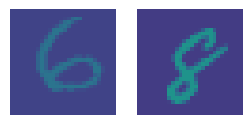

In [14]:
imgs, labels = next(ds_train)
imgs, labels = next(ds_train)

fig, axs = plt.subplots(1, 2, figsize=(3, 1.5))
axs[0].matshow(imgs[0], vmin=0, vmax=1)
axs[1].matshow(imgs[1], vmin=0, vmax=1)
axs[0].axis("off")
axs[1].axis("off")

In [15]:
# Stimulus
stim = stimulus_from_image(imgs[0], coords, stim_config)

In [16]:
# Simulate
init_soln_yesBCs = simulate(init_params, stim)
trained_soln_yesBCs = simulate(trained_params_yesBCs, stim)

In [17]:
# Change the model config for the other architecture
model_config["BC_readouts"] = False

# Build the model
_ = np.random.seed(train_config['seed'])
model_builder = importlib.import_module(model_config["model_builder"])
network = model_builder.build_mnist_model(model_config)

# Set up the parameter training (according to the model)
network, transform = model_builder.setup_param_training(network, train_config)

# Record activity of readouts
network.delete_recordings()
readout_inds = network.readout.nodes.global_cell_index.tolist()
network.cell(readout_inds).record("v")

# Also record the activity of the other cells
network.PR.record("v")
if model_config["nHCs"] > 0:
    network.HC.record("v")
network.RibbonHC.record("RibbonHC_exo")

# Do the ramp-up for the network and save the states
PR_inds = network.PR.nodes.global_cell_index.tolist()
ramp_up_time = np.arange(0, stim_config["outer_ramp_up"], stim_config["dt"])
ramp_up_stim = np.zeros((len(PR_inds), len(ramp_up_time)))

# Initial parameters
init_params = network.get_parameters()

data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], ramp_up_stim, None)
init_soln, init_states = jx.integrate(
    network,
    delta_t=stim_config["dt"],
    data_clamps=data_clamps,
    params=init_params, 
    return_states=True
)

# Have to redefine because network is referenced but not passed
@jit
def simulate(params, stim):
    data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], stim, None)
    soln = jx.integrate(
        network, 
        delta_t=stim_config["dt"],
        data_clamps=data_clamps,
        params=params,
        all_states=init_states,
        checkpoint_lengths=checkpoints
    )
    return soln[:, :-1]

# Load the other parameters
with open('../../params/mnist/trained_params_0504_201_noBC.pkl', 'rb') as f:
    trained_params_noBCs = pickle.load(f)

# Simulate
init_soln_noBCs = simulate(init_params, stim)
trained_soln_noBCs = simulate(trained_params_noBCs, stim)

Number of newly added trainable parameters: 2000. Total number of trainable parameters: 2000
Number of newly added trainable parameters: 200. Total number of trainable parameters: 2200
Number of newly added trainable parameters: 200. Total number of trainable parameters: 2400
Added 10 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.


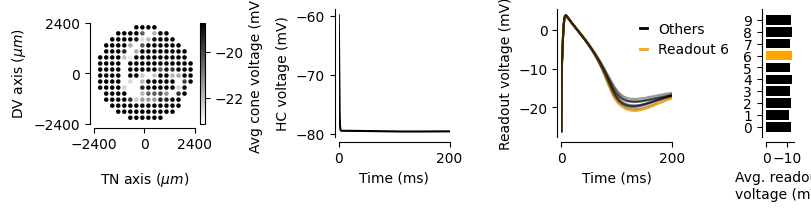

In [20]:
# Plot the activity
time = np.arange(0, stim_config["t_max"], stim_config["dt"])

fig = plt.figure(layout="constrained", figsize=(8, 2))
axs = fig.subplot_mosaic(
    [['cones', '.', 'hc', '.', 'readouts', 'hist']], 
    width_ratios=(4, 2, 4, 1, 4, 1),
    )
# Define the color of the photoreceptor based on its glutamate release to the target readout
cone_v = np.mean(trained_soln_yesBCs[model_config["n_readouts"]:model_config["n_readouts"]+model_config["nPRs"]], axis=1)
voltage_scatter = axs['cones'].scatter(coords[0], coords[1], c=cone_v, cmap='binary', s=5)
axs['cones'].set_aspect('equal')
axs['cones'].set_xlabel(r'TN axis $(\mu m)$')
axs['cones'].set_ylabel(r'DV axis $(\mu m)$')
axs['cones'].set_xticks([-2400, 0, 2400])
axs['cones'].set_yticks([-2400, 0, 2400])
axs['cones'].set_xlim(-2400, 2400)
axs['cones'].set_ylim(-2400, 2400)

divider = make_axes_locatable(axs['cones'])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(voltage_scatter, cax=cax)
cbar.set_label("Avg cone voltage (mV)")
sns.despine(offset=3, ax=axs['cones'])

# Plot readouts
colors = ["k"] * model_config["n_readouts"]
colors[labels[0]] = "orange"
for i in range(0, model_config["n_readouts"]):
    if i == labels[0]:
        axs['readouts'].plot(time, trained_soln_yesBCs[i, :], c=colors[i])
    else:
        axs['readouts'].plot(time, trained_soln_yesBCs[i, :], c=colors[i], alpha=0.4)
legend_elements = [
    Line2D([0], [0], color='k', lw=2),
    Line2D([0], [0], color='orange', lw=2),
]
axs['readouts'].legend(
    legend_elements, 
    ['Others', f'Readout {labels[0]}'], 
    bbox_to_anchor=(0.6, 1),
    handlelength=0.5,
    frameon=False
    )
axs['readouts'].set_xlabel("Time (ms)")
axs['readouts'].set_ylabel("Readout voltage (mV)")
axs['readouts'].set_xlim(0, stim_config['t_max'])
axs['readouts'].set_xticks((0, stim_config['t_max']))
sns.despine(ax=axs['readouts'], offset=3)

axs['hist'].barh(
    np.arange(model_config["n_readouts"]), 
    np.mean(trained_soln_yesBCs[:model_config["n_readouts"], :], axis=1), 
    align='center', 
    color=colors
    )
axs['hist'].invert_xaxis()
axs['hist'].set_yticks(np.arange(model_config["n_readouts"]), np.round(np.arange(model_config["n_readouts"]), 0))
axs['hist'].set_xlabel("Avg. readout\nvoltage (mV)")
sns.despine(ax=axs['hist'], offset=3)

ncells = model_config["n_readouts"] + model_config["nPRs"]
for i in range(ncells, ncells + model_config["nHCs"]):
    axs['hc'].plot(time, trained_soln_yesBCs[i, :], c="k")
axs['hc'].set_xlabel("Time (ms)")
axs['hc'].set_ylabel("HC voltage (mV)")
axs['hc'].set_xlim(0, stim_config['t_max'])
axs['hc'].set_xticks([0, stim_config['t_max']])
sns.despine(ax=axs['hc'], offset=3)

fig.align_xlabels()


In [19]:
# Save
with open("../../paper/fig3/notebooks/mnist_solutions_f3.pkl", "wb") as f:
    pickle.dump({
        "img": imgs[0],
        "stim": stim,
        "solns": [trained_soln_noBCs, trained_soln_yesBCs],
        "init_solns": [init_soln_noBCs, init_soln_yesBCs],
        "labels": labels[0],
        "coords": coords,
        }, f)